## Auto-Regressive Integrated Moving Average Time Series Forecasting for COE Prices

- References: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
- Dataset sources:

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (20,10)
%matplotlib inline

### Load COE-merged Dataset

In [2]:
df = pd.read_csv(r'C:\Users\jengw\OneDrive\Desktop\NUS Masters\2. Pattern Recognition Systems\4. Practice Module\Dataset\Processed Dataset\coe_master.csv', index_col='date')
df = df.iloc[:468,:] # exclude rows associated to 2022

In [3]:
def get_label(date):
    '''
    Convert COE bidding exercise date to 'MMM YYYY (<num>)' format
    '''
    month_dict = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
    
    date = pd.to_datetime(date)
    day = date.day
    month = date.month
    year = date.year

    if day <= 14:
        bidding_exercise = '1'
    elif day >= 15:
        bidding_exercise = '2'

    month_string = month_dict[month]
    year_string = str(year)

    label_string = month_string + ' ' + year_string + ' (' + bidding_exercise + ')'
        
    return label_string

In [4]:
df = df.reset_index()
df.loc[:, 'date'] = pd.to_datetime(df.loc[:, 'date'])
for i in range(df.shape[0]):
    df.loc[i, 'Bidding Exercise'] = get_label(df.loc[i, 'date'])
df = df.set_index('Bidding Exercise').drop(columns=['date'])

In [5]:
coe_cols = ['Quota Premium A', 'Quota Premium B', 'Quota Premium C', 'Quota Premium D', 'Quota Premium E']
coe_df = df[coe_cols]
new_cols = []
for col in coe_df.columns:
    new_col = 'COE - ' + col
    new_cols.append(new_col)
    
coe_df.columns = new_cols

coe_df.head()

,COE - Quota Premium A,COE - Quota Premium B,COE - Quota Premium C,COE - Quota Premium D,COE - Quota Premium E
Bidding Exercise,,,,,
Apr 2002 (1),37201,39509,23001,540,41001
Apr 2002 (2),36000,42101,24001,409,42043
May 2002 (1),35000,40001,24801,402,40001
May 2002 (2),33401,38001,24002,283,38399
Jun 2002 (1),33009,33001,22804,109,34397


In [6]:
coe_df.describe().T

,count,mean,std,min,25%,50%,75%,max
COE - Quota Premium A,468.0,36975.893162,20008.386179,2.0,18799.75,33004.5,51506.25,92100.0
COE - Quota Premium B,468.0,42245.880342,23947.887443,200.0,19508.00,38901.0,60279.00,96210.0
COE - Quota Premium C,468.0,29034.747863,18457.083914,1.0,11301.00,27994.5,45001.00,76310.0
COE - Quota Premium D,468.0,2983.175214,2641.461861,1.0,900.00,1782.0,5426.75,9689.0
COE - Quota Premium E,468.0,43141.670940,24192.872945,3000.0,19898.00,39896.0,62000.00,97889.0


In [10]:
coe_cols = ['Quota Premium A', 'Quota Premium B', 'Quota Premium C', 'Quota Premium D', 'Quota Premium E']

Text(0, 0.5, 'Price')

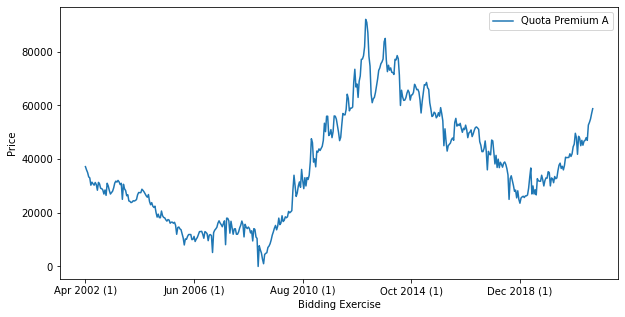

In [11]:
temp_df = df[['Quota Premium A']]
temp_df.plot(figsize=(10,5))
plt.ylabel('Price')

### Plot Time Series Data

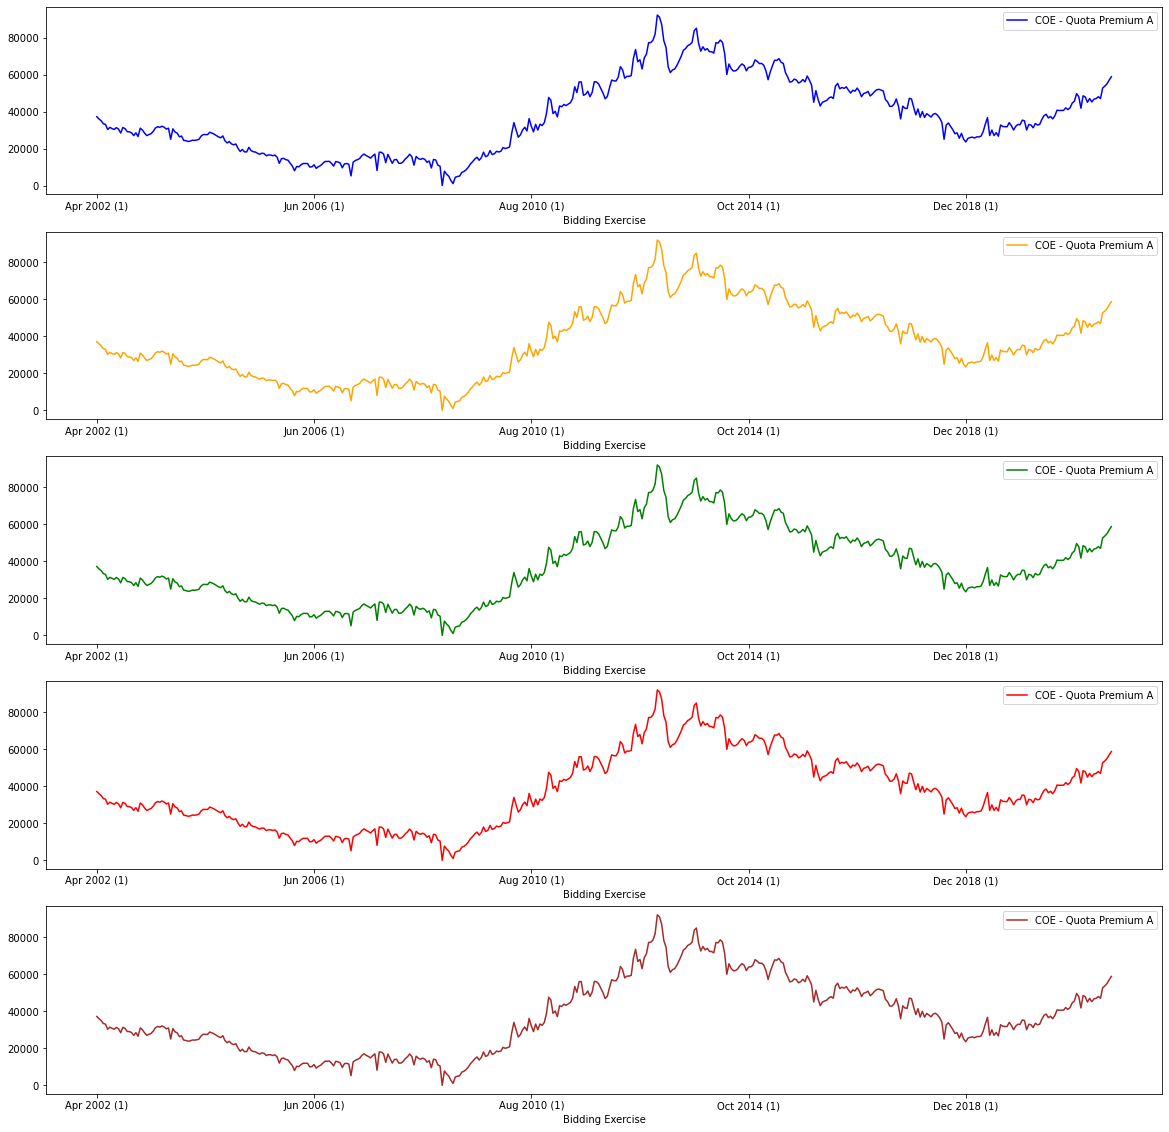

In [12]:
color_palette = ['blue', 'orange', 'green', 'red', 'brown']

plt.figure(figsize=(20,20))

for i, col in enumerate(coe_cols):
    plt.subplot(len(coe_cols), 1, i+1)
    temp_df = coe_df[new_cols[0]]
    temp_df.plot(color=color_palette[i])
    plt.legend()
    

### Finding the value of the d parameter 

In [13]:
# check for stationarity
from statsmodels.tsa.stattools import adfuller

# define function to check if it's stationary
def adfuller_test(coe_prices):
    result=adfuller(coe_prices)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [14]:
# run test for Quota Premium A
adfuller_test(coe_df['COE - Quota Premium A'])

ADF Test Statistic : -1.2471908883311786
p-value : 0.6529733265223088
#Lags Used : 1
Number of Observations : 466
weak evidence against null hypothesis,indicating it is non-stationary 


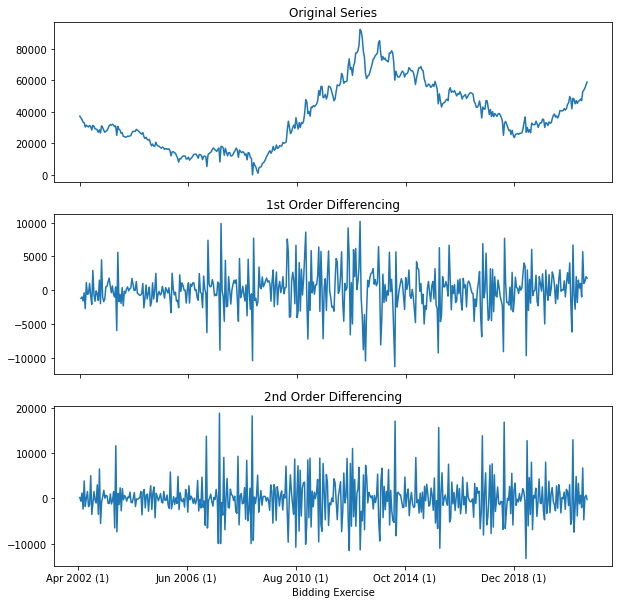

In [15]:
## find the order of differencing that makes the dataset stationary
fig=plt.figure(figsize=(10,10))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312, sharex = ax1)
ax3 = plt.subplot(312, sharex = ax1)


# Original Series
plt.subplot(3, 1, 1)
coe_df['COE - Quota Premium A'].plot()
plt.ylabel(None)
plt.title('Original Series')

# 1st Differencing -> i.e d=1
plt.subplot(3, 1, 2)
coe_df['COE - Quota Premium A'].diff().plot()
plt.ylabel(None)
plt.title('1st Order Differencing')

# 2nd Differencing -> i.e d=2
plt.subplot(3, 1, 3)
coe_df['COE - Quota Premium A'].diff().diff().plot()
plt.title('2nd Order Differencing')
plt.show()

seems like d=2 (First Order Differencing) is suitable as data is stationary

### Determining the value of q

Text(0.5, 1.0, 'Autocorrelation - 1st Order Differencing')

<Figure size 864x576 with 0 Axes>

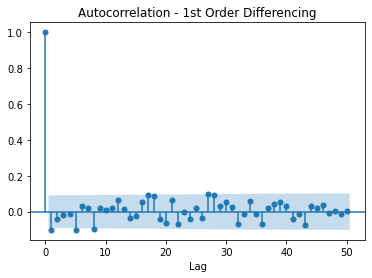

In [20]:
# plot ACF
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,8))
plot_acf(coe_df['COE - Quota Premium A'].diff().dropna(), lags=50)
plt.xlabel('Lag')
plt.title('Autocorrelation - 1st Order Differencing')


2 lags exceeds the significance line => q =2

### Determining the value of p

Text(0.5, 1.0, 'Partial Autocorrelation - 1st Order Differencing')

<Figure size 1440x576 with 0 Axes>

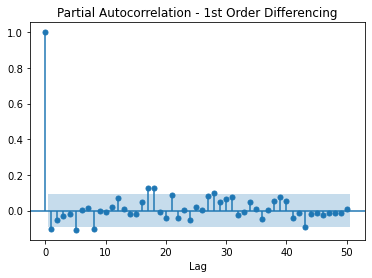

In [21]:
from statsmodels.graphics.tsaplots import plot_pacf
fig = plt.figure(figsize=(20,8))
fig = plot_pacf(coe_df['COE - Quota Premium A'].diff().dropna(), lags=50)
plt.xlabel('Lag')
plt.title('Partial Autocorrelation - 1st Order Differencing')


p=1 as PACF lag 1 is quite significant since is below the significance line,
can try p=5 too

In [78]:
from statsmodels.tsa.arima_model import ARIMA

# define function to do train test split
def train_test_split(cutoff, data_df):
    # train/test split
    train_dataset = data_df.iloc[:cutoff,]
    test_dataset = data_df.iloc[cutoff:,]
    
    return train_dataset, test_dataset


# define function to train model
def train_ARIMA_model(train_dataset, p, d, q):
    # fit model and get model summary
    model=ARIMA(train_dataset,order=(p, d, q))
    model_fit=model.fit()
    display(model_fit.summary())
    
    return model_fit
   
    
# define function to forecast values using ARIMA model
def ARIMA_forecast(model_fit, num_weeks_forecast, data_df):
    pred = pd.DataFrame(model_fit.forecast(num_weeks_forecast)[0], index=data_df.iloc[-num_weeks_forecast:].index)
    pred.columns = ['ARIMA prediction']
    
    return pred
    
    
# define function to plot forecast vs actual
def ARIMA_forecast_plot(model_fit, num_weeks_forecast, data_df, cutoff):
    pred = ARIMA_forecast(model_fit, num_weeks_forecast, data_df)
    actual_forecast_df = pd.concat([data_df[cutoff:], pred], axis=1)
    actual_forecast_df.plot(figsize=(20,10))
    actual_forecast_df.to_csv('arima_forecast.csv')
    return pred                       
    

(420, 1)
(48, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARIMA Model Results                                 
====================================================================================
Dep. Variable:     D2.COE - Quota Premium A   No. Observations:                  418
Model:                       ARIMA(1, 2, 2)   Log Likelihood               -3940.583
Method:                             css-mle   S.D. of innovations           2991.371
Date:                      Fri, 04 Nov 2022   AIC                           7891.166
Time:                              22:47:40   BIC                           7911.344
Sample:                                   2   HQIC                          7899.143
                                                                                    
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.4185      3.508      0.119      0.905      -6.457       7.294
ar.L1.D2.COE - Quota Premium A     0.7783      0.070     11.044      0.000       0.640       0.916
ma.L1.D2.COE - Quota Premium A    -1.8830      0.050    -37.699      0.000      -1.981      -1.785
ma.L2.D2.COE - Quota Premium A     0.8880      0.049     18.053      0.000       0.792       0.984
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2848           +0.0000j            1.2848            0.0000
MA.1            1.0602           -0.0455j            1.0612           -0.0068
MA.2            1.0602           +0.0455j            1.0612            0.0068
-----------------------------------------------------------------------------
"""

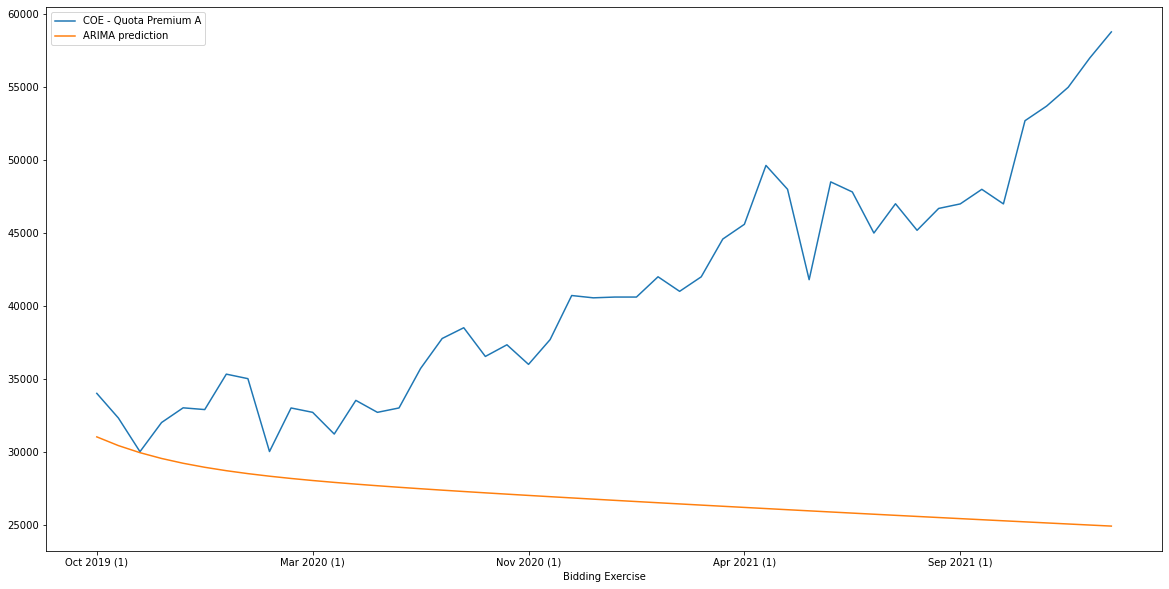

In [79]:
# select parameters for ARIMA training and forecasting
col = 'COE - Quota Premium A'
cutoff=420 ## 420 is chosen to select last 48 COE bidding exercises as test set
num_weeks_forecast = df.shape[0] - cutoff
data_df = coe_df[[col]]
p = 1
d = 2
q = 2

# do train-test split
train_dataset, test_dataset = train_test_split(cutoff, data_df)

print(train_dataset.shape)
print(test_dataset.shape)

# train model
model_fit = train_ARIMA_model(train_dataset, p, d, q)
# plot forecast vs actual
pred = ARIMA_forecast_plot(model_fit, num_weeks_forecast, data_df, cutoff)

In [24]:
model_fit.save('Model/Univariate/ARIMA.pkl')

coef for AR1, MA1, MA2 are significantly high and "P>|z|" << 0.05 for all 3 elements = this set of values of (p,d,q) is good

### Performance evaluation of ARIMA

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def print_errors(actual, pred):
    rmse = math.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    
    print('RMSE: ', rmse)
    print('MAE: ', mae)
    print('MAPE: ', mape)    

In [26]:
import math

actual = test_dataset.values
y_pred = pred['ARIMA prediction'].values

print_errors(actual, y_pred)

RMSE:  16592.88524903283
MAE:  14023.606691398652
MAPE:  32.04582888144375


### Refine ARIMA

### SARIMA Model

In [27]:
import statsmodels.api as sm

## train SARIMA
model=sm.tsa.statespace.SARIMAX(train_dataset,order=(1, 2, 2),seasonal_order=(1,2,2,4))
results=model.fit()


C:\Users\jengw\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\jengw\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\jengw\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [28]:
## predict
sarima_pred = pd.Series(results.predict(start=cutoff,end=cutoff+num_weeks_forecast-1,dynamic=True))

sarima_forecast_df = test_dataset.copy()
sarima_forecast_df['SARIMA prediction'] = sarima_pred.values.tolist()


C:\Users\jengw\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [29]:
type(train_dataset)

pandas.core.frame.DataFrame

<AxesSubplot:xlabel='Bidding Exercise'>

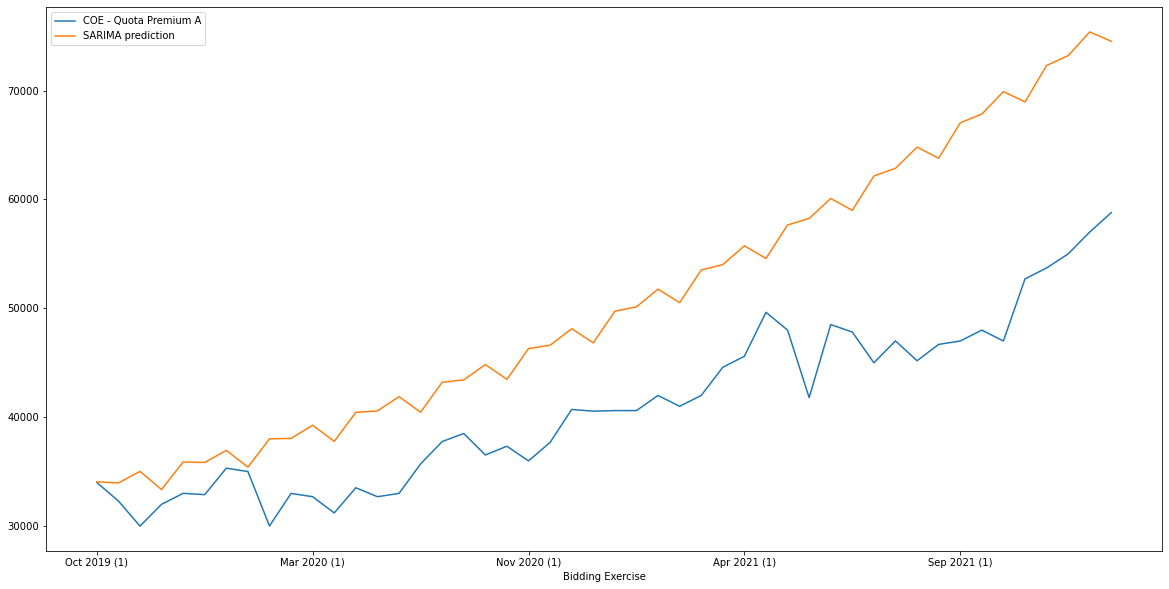

In [30]:
actual_sarima_forecast_df = pd.concat([train_dataset, sarima_forecast_df], axis=0)
actual_sarima_forecast_df.iloc[-num_weeks_forecast-1,1] = actual_sarima_forecast_df.iloc[-num_weeks_forecast-1,0] 
actual_sarima_forecast_df[cutoff:].plot(figsize=(20,10))

In [31]:
results.save('Model/Univariate/SARIMA.pkl')

In [77]:
actual_sarima_forecast_df[cutoff:].to_csv('sarima_forecast.csv')

In [50]:
actual = actual_sarima_forecast_df.iloc[-num_weeks_forecast:,0].values
pred = actual_sarima_forecast_df.iloc[-num_weeks_forecast:,1].values
print_errors(actual, pred)

RMSE:  11439.199315338003
MAE:  9810.832151921217
MAPE:  22.759601747017978


In [51]:
print(type(sarima_forecast_df))

<class 'pandas.core.frame.DataFrame'>


### VARMA Model

In [80]:
from statsmodels.tsa.statespace.varmax import VARMAX

# define function to get multivariate train and test dataset
def multi_train_test_split(df, cols, cutoff):
    temp_df = df[cols]
    multi_train_dataset = temp_df.iloc[:cutoff,]
    multi_test_dataset = temp_df.iloc[cutoff:,]
    
    return multi_train_dataset, multi_test_dataset


# define function to train VARMA model
def train_VARMA(multi_train_dataset, p, q):
    model = VARMAX(multi_train_dataset, order=(p,q))
    model_fit = model.fit()
    
    return model_fit


## define function to forecast using VARMA
def VARMA_forecast(model_fit, num_weeks_forecast, multi_test_dataset):
    pred = model_fit.forecast(steps=num_weeks_forecast, index=multi_test_dataset.index)
    
    return pred


# forecast using VARMA and plot
def VARMA_forecast_plot(model_fit, num_weeks_forecast, multi_train_dataset, multi_test_dataset, target_col, cutoff):
    pred = VARMA_forecast(model_fit, num_weeks_forecast, multi_test_dataset)
    pred.columns = [col+'_Forecast' for col in pred.columns]
    actual_df = pd.concat([multi_train_dataset, multi_test_dataset], axis=0)
    actual_forecast_df = pd.concat([actual_df[[target_col]], pred[[target_col+'_Forecast']]], axis=1)
    actual_forecast_df.columns = ['COE - Quota Premium A', 'VARMA prediction']
    actual_forecast_df[cutoff:].plot(figsize=(20,10))
    
    return actual_forecast_df


,COE - Quota Premium A,VARMA prediction
Bidding Exercise,,
Apr 2002 (1),37201,NaN
Apr 2002 (2),36000,NaN
May 2002 (1),35000,NaN
May 2002 (2),33401,NaN
Jun 2002 (1),33009,NaN
...,...,...
Oct 2021 (2),52709,41943.111826
Nov 2021 (1),53709,42012.976477
Nov 2021 (2),55001,42078.356292


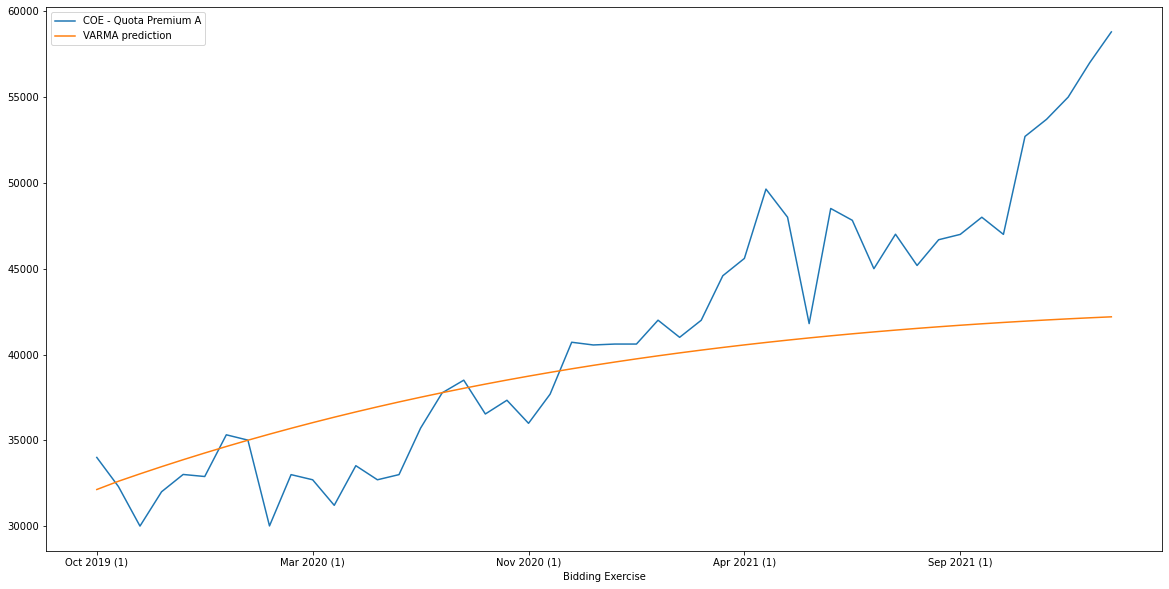

In [81]:
cols = ['Quota Premium A', 'Quota A', 'Total Bids Received A']

# split dataset
multi_train_dataset, multi_test_dataset = multi_train_test_split(df, cols, cutoff)

# train model
model_fit = train_VARMA(multi_train_dataset.astype('float32'), 1, 2)

# get predictions and plot
actual_forecast_df = VARMA_forecast_plot(model_fit, num_weeks_forecast, multi_train_dataset, multi_test_dataset, 'Quota Premium A', cutoff)
actual_forecast_df

In [82]:
actual_forecast_df[cutoff:].to_csv('varma_forecast.csv')

In [73]:
actual = actual_forecast_df.iloc[-num_weeks_forecast:,0].values
pred = actual_forecast_df.iloc[-num_weeks_forecast:,1].values
print_errors(actual, pred)

RMSE:  5655.440546943169
MAE:  4125.502960236584
MAPE:  9.257088970262817


In [75]:
multi_train_dataset

,Quota Premium A,Quota A,Total Bids Received A
Bidding Exercise,,,
Apr 2002 (1),37201,1110,2484
Apr 2002 (2),36000,1149,1890
May 2002 (1),35000,1128,1705
May 2002 (2),33401,1111,1320
Jun 2002 (1),33009,1111,1382
...,...,...,...
Jul 2019 (2),26667,1623,1902
Aug 2019 (1),32725,1059,2023
Aug 2019 (2),31917,1062,1725


In [34]:
model_fit.save('Model/Univariate/VARMA.pkl')

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [36]:
def generate_col_to_drop(category):
  col = ['Quota Premium A', 'Quota Premium B', 'Quota Premium C', 'Quota Premium D', 'Quota Premium E']
  col_header = ['Quota ', 'Total Bids Received ', 'Number of Successful Bids ']
  cat = 'ABCDE'
  cat_to_drop = list(cat.replace(category, ''))
  for i in cat_to_drop:
    for j in col_header:
      col.append(j + i)
  return col

In [37]:
data = pd.read_csv(r'C:\Users\jengw\OneDrive\Desktop\NUS Masters\2. Pattern Recognition Systems\4. Practice Module\Dataset\Cleaned Dataset\merge_drop.csv', index_col = 0)
data.shape

(468, 86)

BS test passed for category A with p_value = 0.0
KMO test passed for category A with value = 0.7545092163959755
Cat A Eigenvalues         : [5.4015e+01 5.9070e+00 2.8410e+00 2.4420e+00 1.0150e+00 6.3800e-01
 4.9300e-01 4.7000e-01 2.6400e-01 2.4400e-01 1.7700e-01 1.3500e-01
 1.0900e-01 8.1000e-02 6.2000e-02 5.0000e-02 4.4000e-02 2.7000e-02
 2.6000e-02 2.1000e-02]
Cat A % Variance Explained: [7.8116e+01 8.5420e+00 4.1080e+00 3.5320e+00 1.4680e+00 9.2300e-01
 7.1300e-01 6.7900e-01 3.8100e-01 3.5300e-01 2.5600e-01 1.9500e-01
 1.5800e-01 1.1800e-01 8.9000e-02 7.2000e-02 6.4000e-02 4.0000e-02
 3.7000e-02 3.1000e-02]
Cat A % Cumulative Var Explained: [78.116 86.658 90.766 94.298 95.766 96.689 97.402 98.081 98.462 98.815
 99.071 99.266 99.424 99.542 99.631 99.703 99.767 99.807 99.844 99.875]


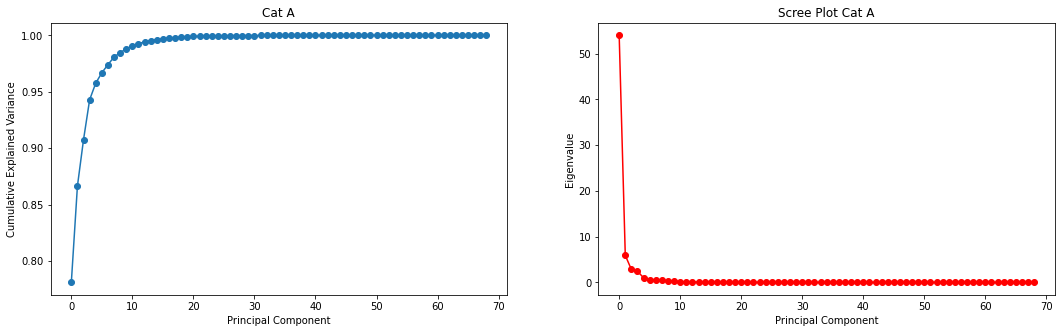

In [38]:
category = 'A'
X = data.drop(generate_col_to_drop(category),axis=1)
features = list(X.columns.values)

# Barlett Sphericity & Kaiser-Meyer-Olkin test
BS_passed = False
KMO_passed = False
chi_square_value, p_value = calculate_bartlett_sphericity(X)
if (p_value < 0.05):
  BS_passed = True
  print("BS test passed for category {} with p_value = {}".format(category, p_value))
else:
  print("BS test fail for category {} with p_value = {}".format(category, p_value))

kmo_all,kmo_model=calculate_kmo(X)
if (kmo_model > 0.5):
  KMO_passed = True
  print("KMO test passed for category {} with value = {}".format(category, kmo_model))
else:
  print("KMO test fail for category {} with value = {}".format(category, kmo_model))

if BS_passed and KMO_passed:
  # Standardise data & apply PCA
  data_std = StandardScaler().fit_transform(X)
  n_components = len(features)
  pca = PCA(n_components, random_state=42).fit(data_std)

  # eigenvalues, variance explained    
  eigenvalues = pca.explained_variance_
  var_expln = np.round(pca.explained_variance_ratio_ * 100,decimals=3)
  npc = 20 # display
  print('Cat {} Eigenvalues         :'.format(category),np.round(eigenvalues[0:npc],decimals=3))
  print('Cat {} % Variance Explained:'.format(category),var_expln[0:npc])
  print('Cat {} % Cumulative Var Explained:'.format(category), np.cumsum(var_expln[0:npc]))

  # Scree Plot
  fig = plt.figure(figsize=(18,5))
  plt.subplot(1, 2, 1)
  plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
  plt.title('Cat {}'.format(category))
  plt.xlabel('Principal Component')
  plt.ylabel('Cumulative Explained Variance')

  plt.subplot(1, 2, 2)
  plt.plot(eigenvalues, 'ro-')
  plt.title('Scree Plot Cat {}'.format(category))
  plt.xlabel('Principal Component')
  plt.ylabel('Eigenvalue')
  plt.show()

In [39]:
# generate PC labels:
PCs=[]
for l in range(1,n_components+1):
    PCs.append("PC"+str(l))

In [41]:
## Selecting Number of PC to be 4 due to: cumulative > 65%, cumulative communalities > 0.5 for all variables
no_pc = 5

# Print out the Component Scores
PC_scores = pca.fit_transform(data_std) # PC scores for downstream analytics
scores = pd.DataFrame(PC_scores[:,0:no_pc],columns=PCs[0:no_pc], index=df.index)

## merge PC scores with target variable
pca_coe_df = pd.concat([scores, coe_df[[col]]], axis=1)
pca_coe_df

,PC1,PC2,PC3,PC4,PC5,COE - Quota Premium A
Bidding Exercise,,,,,,
Apr 2002 (1),-11.384867,-2.906990,0.699696,4.257790,1.871552,37201
Apr 2002 (2),-11.382702,-2.652822,0.780303,4.184517,-0.685643,36000
May 2002 (1),-11.356144,-2.566344,0.810298,4.217940,-1.132820,35000
May 2002 (2),-11.333255,-2.484609,0.995151,4.585454,1.401220,33401
Jun 2002 (1),-11.352310,-2.622939,0.940295,4.530852,0.242422,33009
...,...,...,...,...,...,...
Oct 2021 (2),11.712950,-0.436033,4.888739,-1.574868,-0.435800,52709
Nov 2021 (1),11.882557,-0.276886,5.014107,-1.099195,0.104298,53709
Nov 2021 (2),11.851468,-0.843940,5.061638,-0.628625,1.935397,55001


In [42]:
# split dataset
cols = pca_coe_df.columns
pca_train_dataset, pca_test_dataset = multi_train_test_split(pca_coe_df, cols, cutoff)

# train model
model_fit = train_VARMA(pca_train_dataset, 1, 2)



TypeError: VARMA_forecast_plot() missing 1 required positional argument: 'cutoff'

,COE - Quota Premium A,VARMA prediction
Bidding Exercise,,
Apr 2002 (1),37201,NaN
Apr 2002 (2),36000,NaN
May 2002 (1),35000,NaN
May 2002 (2),33401,NaN
Jun 2002 (1),33009,NaN
...,...,...
Oct 2021 (2),52709,50850.677481
Nov 2021 (1),53709,50559.080682
Nov 2021 (2),55001,50278.212391


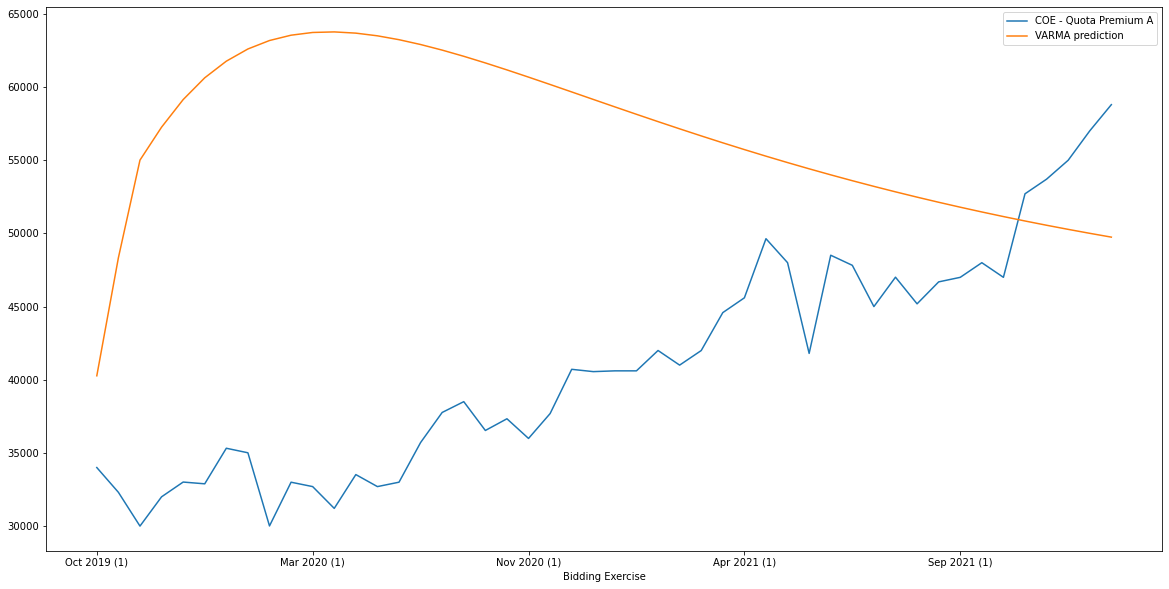

In [44]:
# get predictions and plot
actual_forecast_df = VARMA_forecast_plot(model_fit, num_weeks_forecast, pca_train_dataset, pca_test_dataset, col, cutoff)
actual_forecast_df

In [45]:
actual = actual_forecast_df.iloc[-num_weeks_forecast:,0].values
pred = actual_forecast_df.iloc[-num_weeks_forecast:,1].values
print_errors(actual, pred)

RMSE:  19648.238650624906
MAE:  16946.217793059925
MAPE:  46.6490368592536


In [76]:
## Selecting Number of PC to be 4 due to: cumulative > 65%, cumulative communalities > 0.5 for all variables
no_pc = 2

# Print out the Component Scores
PC_scores = pca.fit_transform(data_std) # PC scores for downstream analytics
scores = pd.DataFrame(PC_scores[:,0:no_pc],columns=PCs[0:no_pc], index=df.index)

## merge PC scores with target variable
pca_coe_df = pd.concat([scores, coe_df[[col]]], axis=1)
pca_coe_df[:cutoff]

,PC1,PC2,COE - Quota Premium A
Bidding Exercise,,,
Apr 2002 (1),-11.384867,-2.906990,37201
Apr 2002 (2),-11.382702,-2.652822,36000
May 2002 (1),-11.356144,-2.566344,35000
May 2002 (2),-11.333255,-2.484609,33401
Jun 2002 (1),-11.352310,-2.622939,33009
...,...,...,...
Jul 2019 (2),9.675561,-1.681277,26667
Aug 2019 (1),9.922495,-1.589211,32725
Aug 2019 (2),9.763148,-1.366921,31917


,COE - Quota Premium A,VARMA prediction
Bidding Exercise,,
Apr 2002 (1),37201,NaN
Apr 2002 (2),36000,NaN
May 2002 (1),35000,NaN
May 2002 (2),33401,NaN
Jun 2002 (1),33009,NaN
...,...,...
Oct 2021 (2),52709,31576.870015
Nov 2021 (1),53709,31469.539667
Nov 2021 (2),55001,31359.701667


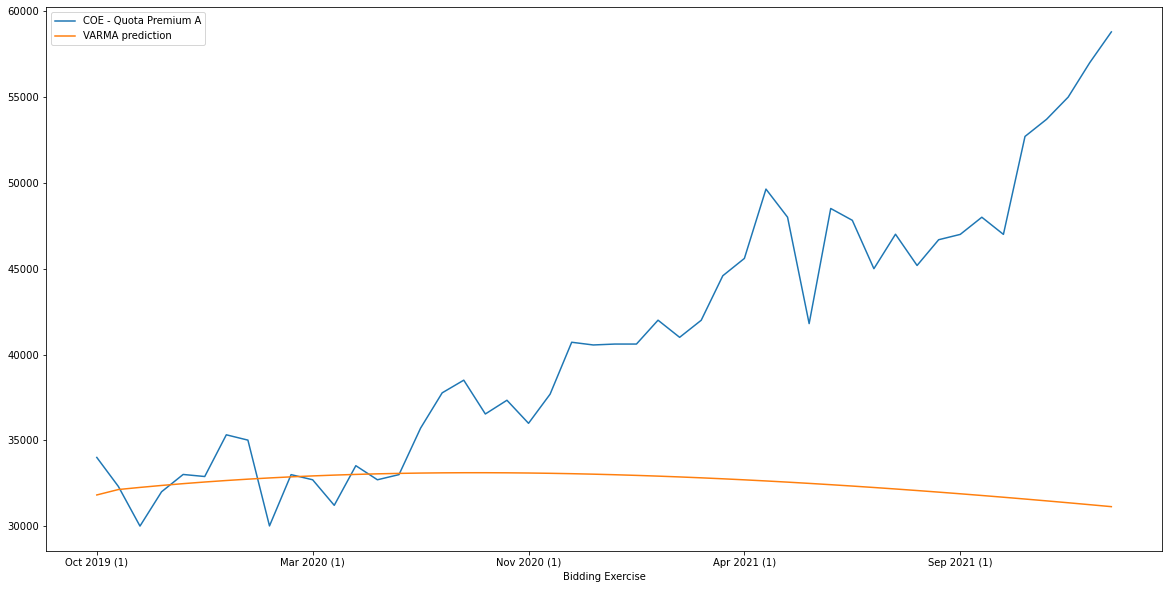

In [48]:
# split dataset
cols = pca_coe_df.columns
pca_train_dataset, pca_test_dataset = multi_train_test_split(pca_coe_df, cols, cutoff)

# train model
model_fit = train_VARMA(pca_train_dataset, 1, 2)

# get predictions and plot
actual_forecast_df = VARMA_forecast_plot(model_fit, num_weeks_forecast, pca_train_dataset, pca_test_dataset, col, cutoff)
actual_forecast_df

In [49]:
actual = actual_forecast_df.iloc[-num_weeks_forecast:,0].values
pred = actual_forecast_df.iloc[-num_weeks_forecast:,1].values
print_errors(actual, pred)

RMSE:  11603.730302145004
MAE:  8790.215355462986
MAPE:  18.936637721675982


### Deep Learning Models

In [84]:
## Deep Learning
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,EarlyStopping
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [104]:


# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# fix random seed for reproducibility
tf.random.set_seed(7)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data_df = coe_df[[col]]
dataset = scaler.fit_transform(data_df)


# split into train, validation and test sets
look_back = 36
val_length = 48
train_nn_dataset = dataset[:-num_weeks_forecast-val_length]
val_nn_dataset = dataset[-num_weeks_forecast-val_length-look_back-1:-num_weeks_forecast]
test_nn_dataset = dataset[-num_weeks_forecast:]

# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train_nn_dataset, look_back)
valX, valY = create_dataset(val_nn_dataset, look_back)
testY = test_nn_dataset # get test values

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))

print("trainX shape:", trainX.shape)
print("trainY shape:", trainY.shape)
print("valX shape:", valX.shape)
print("valY shape:", valY.shape)
print("testX shape:", test_nn_dataset.shape)
print("testY shape:", testY.shape)


trainX shape: (335, 1, 36)
trainY shape: (335,)
valX shape: (48, 1, 36)
valY shape: (48,)
testX shape: (48, 1)
testY shape: (48, 1)


In [105]:
# create and fit the LSTM network
modelname   = 'lstm32_lb36'
model = Sequential()
model.add(LSTM(16, activation='relu', input_shape=(1, look_back)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

## print model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 16)                3392      
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,409
Trainable params: 3,409
Non-trainable params: 0
_________________________________________________________________


### Create Callbacks to save best model

In [106]:
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience = 100, restore_best_weights=True)

folderpath = r'C:\Users\jengw\OneDrive\Desktop\NUS Masters\2. Pattern Recognition Systems\4. Practice Module\Code\Model\\'
model_path        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(model_path, 
                                  monitor='val_loss', # save model when loss on validation set is minimised
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='min')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [early_stopping, checkpoint,csv_logger]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print(callbacks_list[2])
print('')
print("Path to model:", model_path)
print("Path to log:  ", folderpath+modelname+'.csv')

# save scaler
scaler_name = modelname + "-scaler.gz"
scaler_path = folderpath + scaler_name
joblib.dump(scaler, scaler_path) 

Callbacks created:

Path to model: C:\Users\jengw\OneDrive\Desktop\NUS Masters\2. Pattern Recognition Systems\4. Practice Module\Code\Model\\lstm32_lb36.hdf5
Path to log:   C:\Users\jengw\OneDrive\Desktop\NUS Masters\2. Pattern Recognition Systems\4. Practice Module\Code\Model\\lstm32_lb36.csv


['C:\\Users\\jengw\\OneDrive\\Desktop\\NUS Masters\\2. Pattern Recognition Systems\\4. Practice Module\\Code\\Model\\\\lstm32_lb36-scaler.gz']

In [107]:
## train model
model.fit(trainX, 
          trainY, 
          validation_data=(valX, valY),  
          epochs=200, 
          batch_size=4, 
          verbose=2, 
          callbacks=callbacks_list)

Epoch 1/200
84/84 - 1s - loss: 0.1304 - val_loss: 0.0054 - 1s/epoch - 16ms/step
Epoch 2/200
84/84 - 0s - loss: 0.0281 - val_loss: 0.0020 - 388ms/epoch - 5ms/step
Epoch 3/200
84/84 - 0s - loss: 0.0218 - val_loss: 0.0023 - 405ms/epoch - 5ms/step
Epoch 4/200
84/84 - 0s - loss: 0.0215 - val_loss: 0.0041 - 411ms/epoch - 5ms/step
Epoch 5/200
84/84 - 0s - loss: 0.0223 - val_loss: 0.0035 - 342ms/epoch - 4ms/step
Epoch 6/200
84/84 - 0s - loss: 0.0202 - val_loss: 0.0027 - 361ms/epoch - 4ms/step
Epoch 7/200
84/84 - 0s - loss: 0.0233 - val_loss: 0.0022 - 356ms/epoch - 4ms/step
Epoch 8/200
84/84 - 0s - loss: 0.0157 - val_loss: 0.0034 - 377ms/epoch - 4ms/step
Epoch 9/200
84/84 - 0s - loss: 0.0178 - val_loss: 0.0027 - 362ms/epoch - 4ms/step
Epoch 10/200
84/84 - 0s - loss: 0.0203 - val_loss: 0.0018 - 405ms/epoch - 5ms/step
Epoch 11/200
84/84 - 0s - loss: 0.0145 - val_loss: 0.0029 - 375ms/epoch - 4ms/step
Epoch 12/200
84/84 - 0s - loss: 0.0166 - val_loss: 0.0028 - 373ms/epoch - 4ms/step
Epoch 13/200
84

In [108]:
# define function for LSTM model to make step-by-step predictions - use model prediction for t=t+1 and append it to look back array to predict t=t+2
# A rolling-forecast scenario will be used, also called walk-forward model validation.
# Each time step of the test dataset will be walked one at a time. A model will be used to make a forecast for the time step, 
# then the actual expected value for the next month from the test set will be taken and made available to the model for the forecast on the next time step.
def make_forecasts(model, testX, n_forecast=48):
       
    testPredict = []
    
    for i in range(n_forecast):
        if i == 0:
            seq = testX[i] # get first set of lookback values
            seq = np.reshape(seq, (1, 1, seq.shape[0]))
            pred = model.predict(seq, verbose=0) # predict next time step
            testPredict.append(pred) # add first prediction to testPredict array
        else:
            seq = seq[0][0][1:] # remove first element of lookback values
            seq = np.append(seq, [pred])# append previous time-step prediction
            seq = np.reshape(seq, (1, 1, len(seq)))
            pred = model.predict(seq, verbose=0) # predict next time step
            testPredict.append(pred)          
    
    testPredict = np.reshape(testPredict, (len(testPredict), 1))
    
    return testPredict

RMSE:  3844.3751216069973
MAE:  2787.8098958333326
MAPE:  6.2701547033116425


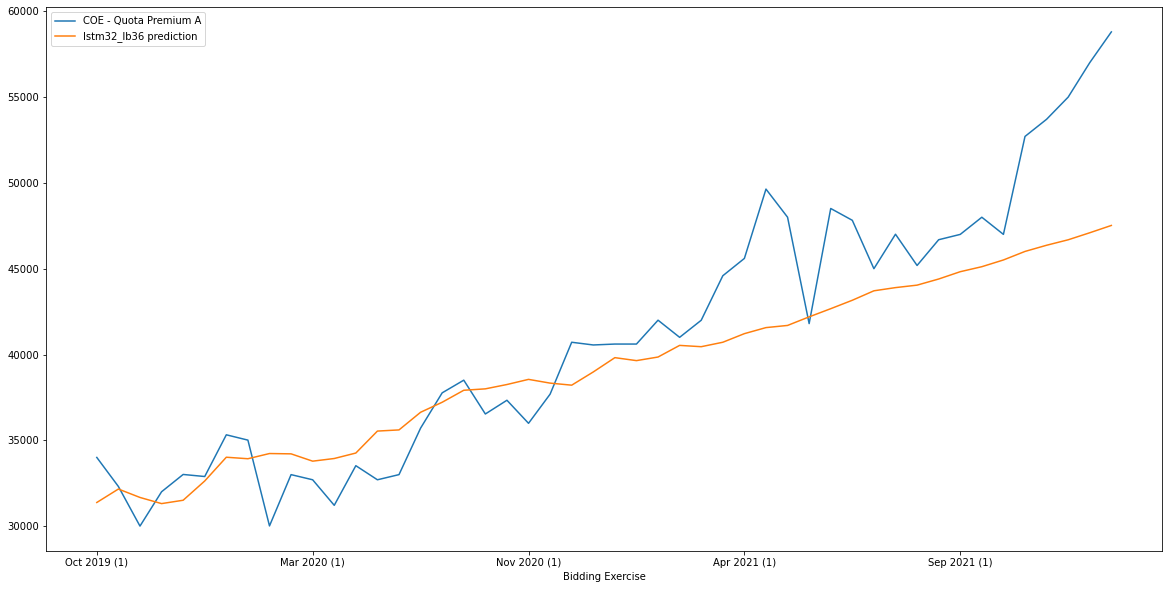

In [109]:
# load model and scaler
lstm_model = load_model(model_path)
lstm_scaler = joblib.load(scaler_path) 

# load and transform data
testX = val_nn_dataset[-look_back:].reshape(1,-1)
testPredict = make_forecasts(lstm_model, testX, 48)
testPredict = lstm_scaler.inverse_transform(testPredict)
testY = test_nn_dataset
testY = lstm_scaler.inverse_transform(testY)

# make forecasts
lstm_forecast_df = test_dataset.copy()
lstm_forecast_df['lstm32_lb36 prediction'] = testPredict[:,0]
actual_lstm_forecast_df = pd.concat([train_dataset, lstm_forecast_df], axis=0)
actual_lstm_forecast_df.iloc[-num_weeks_forecast-1,1] = actual_lstm_forecast_df.iloc[-num_weeks_forecast-1,0] 
actual_lstm_forecast_df[cutoff:].plot(figsize=(20,10))

# print errors
print_errors(testY[:,0], testPredict[:,0])



In [91]:
actual_lstm_forecast_df[cutoff:].to_csv('lstm32_lb36.csv')

In [41]:
print(testX)

[[0.40172425 0.41811983 0.42279963 0.41259311 0.39549176 0.37034463
  0.27142826 0.355024   0.36695694 0.34740168 0.32798758 0.30400226
  0.30896436 0.27746531 0.306163   0.27142826 0.25587961 0.27686812
  0.28141762 0.28413212 0.27890942 0.28555452 0.28564138 0.28944168
  0.31658668 0.360453   0.39851028 0.29314426 0.32581598 0.2931334
  0.31039762 0.28952855 0.3553063  0.34653304 0.34507807 0.34481748]]


In [ ]:
records = pd.read_csv(folderpath+modelname +'.csv')
plt.figure(figsize=(10,5))
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.title('Loss value',fontsize=12)
plt.legend()


NameError: name 'modelname' is not defined

Note: training loss is constantly higher than validation loss which is to be expected due to 2 reasons - some units are dropped out during training due to the dropout layer but the full network is used when forecasting on the test set, which naturally makes it more accurate. Also, regularization is added to the loss function when training but not during validation, which explains why the loss calculated on the training set is constantly higher. https://towardsdatascience.com/what-your-validation-loss-is-lower-than-your-training-loss-this-is-why-5e92e0b1747e

#### Best models so far

Without validation set, model saved based on minimum value of loss
- look_back = 24, lstm = 10, dropout=0, batch_size=8, epoch = 200, MAPE = 10.68%
- look_back=48, lstm=16, dropout=0.1, batch_size=8, epoch=200, MAPE = 8.68%)
- look_back=48, lstm = 4, dropout=0, batch_size=8, epoch=50, MAPE=12.72%
- look_back=48, lstm = 4, dropout=0, batch_size=8, epoch=100, MAPE=7.17%

After adding validation set, valmodel saved based on minimum value of valloss
- look_back=48, lstm = 4, dropout=0, batch_size=8, epoch=50, MAPE=32.38%
- look_back=48, lstm = 4, dropout=0, batch_size=8, epoch=100, MAPE=24.70%
- look_back=48, lstm = 4, dropout=0, batch_size=8, epoch=200, MAPE=17.8%
- look_back=48, lstm = 4, dropout=0, batch_size=8, epoch=400, MAPE=25.09%
- look_back=48, lstm = 16, dropout=0.1, batch_size=8, epoch=200, MAPE=41.23%
- look_back=48, lstm = 16, dropout=0.2, batch_size=8, epoch=200, MAPE=27.23%
- look_back=48, lstm = 16, dropout=0.2, batch_size=4, epoch=200, MAPE=11.00%
- look_back=48, lstm = 16, dropout=0.2, batch_size=2, epoch=200, MAPE=24.58%
- look_back=48, lstm = 32, dropout=0.2, batch_size=4, epoch=200, MAPE=33.68%
- look_back=24, lstm = 32, dropout=0.2, batch_size=4, epoch=200, MAPE=20.70%
- look_back=24, lstm = 16, dropout=0.2, batch_size=4, epoch=200, MAPE=23.23%
- look_back=36, lstm = 16, dropout=0.2, batch_size=4, epoch=200, MAPE=6.27% --------> BEST

In [49]:
def create_dataset_for_forecast(dataset, look_back=48):
    dataX = []
    for i in range(look_back):
        dataX.append(dataset[i][0])
    return np.array(dataX)

### Stacked LSTM Model

In [98]:
# fix random seed for reproducibility
tf.random.set_seed(7)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data_df)

# split into train, validation and test sets
look_back = 36
val_length = 48
train_nn_dataset = dataset[:-num_weeks_forecast-val_length]
val_nn_dataset = dataset[-num_weeks_forecast-val_length-look_back-1:-num_weeks_forecast]
test_nn_dataset = dataset[-num_weeks_forecast:]

# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train_nn_dataset, look_back)
valX, valY = create_dataset(val_nn_dataset, look_back)
testY = test_nn_dataset # get test values

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))

print("trainX shape:", trainX.shape)
print("trainY shape:", trainY.shape)
print("valX shape:", valX.shape)
print("valY shape:", valY.shape)
print("test_nn_dataset shape:", test_nn_dataset.shape)
print("val_nn_dataset shape:", val_nn_dataset.shape)
print("testY shape:", testY.shape)

trainX shape: (335, 1, 36)
trainY shape: (335,)
valX shape: (48, 1, 36)
valY shape: (48,)
test_nn_dataset shape: (48, 1)
val_nn_dataset shape: (85, 1)
testY shape: (48, 1)


In [99]:
# create and fit the LSTM network
model2name = 'stack_lstm_16_8_lb36'
model2 = Sequential()
model2.add(LSTM(16, activation='relu', return_sequences=True, input_shape=(1, look_back)))
model2.add(Dropout(0.2))
model2.add(LSTM(8, activation='relu', return_sequences=True))
model2.add(Dropout(0.2))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1, 16)             3392      
                                                                 
 dropout_7 (Dropout)         (None, 1, 16)             0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 8)              800       
                                                                 
 dropout_8 (Dropout)         (None, 1, 8)              0         
                                                                 
 dense_5 (Dense)             (None, 1, 1)              9         
                                                                 
Total params: 4,201
Trainable params: 4,201
Non-trainable params: 0
_________________________________________________________________


In [100]:
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience = 100, restore_best_weights=True)

folderpath = r'C:\Users\jengw\OneDrive\Desktop\NUS Masters\2. Pattern Recognition Systems\4. Practice Module\Code\Model\Univariate\\'
model_path        = folderpath + model2name + ".hdf5"
checkpoint      = ModelCheckpoint(model_path, 
                                  monitor='val_loss', # save model when loss on validation set is minimised
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='min')

csv_logger      = CSVLogger(folderpath+model2name +'.csv')                       # Step 2
callbacks_list  = [early_stopping,checkpoint,csv_logger]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print(callbacks_list[2])
print('')
print("Path to model:", model_path)
print("Path to log:  ", folderpath+model2name+'.csv')

# save scaler
scaler_name = model2name + "-scaler.gz"
scaler_path = folderpath + scaler_name
joblib.dump(scaler, scaler_path) 

Callbacks created:

Path to model: C:\Users\jengw\OneDrive\Desktop\NUS Masters\2. Pattern Recognition Systems\4. Practice Module\Code\Model\Univariate\\stack_lstm_16_8_lb36.hdf5
Path to log:   C:\Users\jengw\OneDrive\Desktop\NUS Masters\2. Pattern Recognition Systems\4. Practice Module\Code\Model\Univariate\\stack_lstm_16_8_lb36.csv


['C:\\Users\\jengw\\OneDrive\\Desktop\\NUS Masters\\2. Pattern Recognition Systems\\4. Practice Module\\Code\\Model\\Univariate\\\\stack_lstm_16_8_lb36-scaler.gz']

In [101]:
## train model
model2.fit(trainX, 
          trainY, 
          validation_data=(valX, valY),  
          epochs=200, 
          batch_size=16, 
          verbose=2, 
          callbacks=callbacks_list)

Epoch 1/200
21/21 - 2s - loss: 0.2216 - val_loss: 0.1067 - 2s/epoch - 89ms/step
Epoch 2/200
21/21 - 0s - loss: 0.1854 - val_loss: 0.0751 - 231ms/epoch - 11ms/step
Epoch 3/200
21/21 - 0s - loss: 0.1454 - val_loss: 0.0281 - 202ms/epoch - 10ms/step
Epoch 4/200
21/21 - 0s - loss: 0.1234 - val_loss: 0.0250 - 234ms/epoch - 11ms/step
Epoch 5/200
21/21 - 0s - loss: 0.1153 - val_loss: 0.0185 - 214ms/epoch - 10ms/step
Epoch 6/200
21/21 - 0s - loss: 0.1083 - val_loss: 0.0136 - 209ms/epoch - 10ms/step
Epoch 7/200
21/21 - 0s - loss: 0.0997 - val_loss: 0.0091 - 198ms/epoch - 9ms/step
Epoch 8/200
21/21 - 0s - loss: 0.0971 - val_loss: 0.0088 - 209ms/epoch - 10ms/step
Epoch 9/200
21/21 - 0s - loss: 0.0908 - val_loss: 0.0059 - 200ms/epoch - 10ms/step
Epoch 10/200
21/21 - 0s - loss: 0.0841 - val_loss: 0.0043 - 191ms/epoch - 9ms/step
Epoch 11/200
21/21 - 0s - loss: 0.0805 - val_loss: 0.0034 - 216ms/epoch - 10ms/step
Epoch 12/200
21/21 - 0s - loss: 0.0784 - val_loss: 0.0033 - 200ms/epoch - 10ms/step
Epoch 

RMSE:  13894.337962955737
MAE:  11687.123046875
MAPE:  26.161014275951715


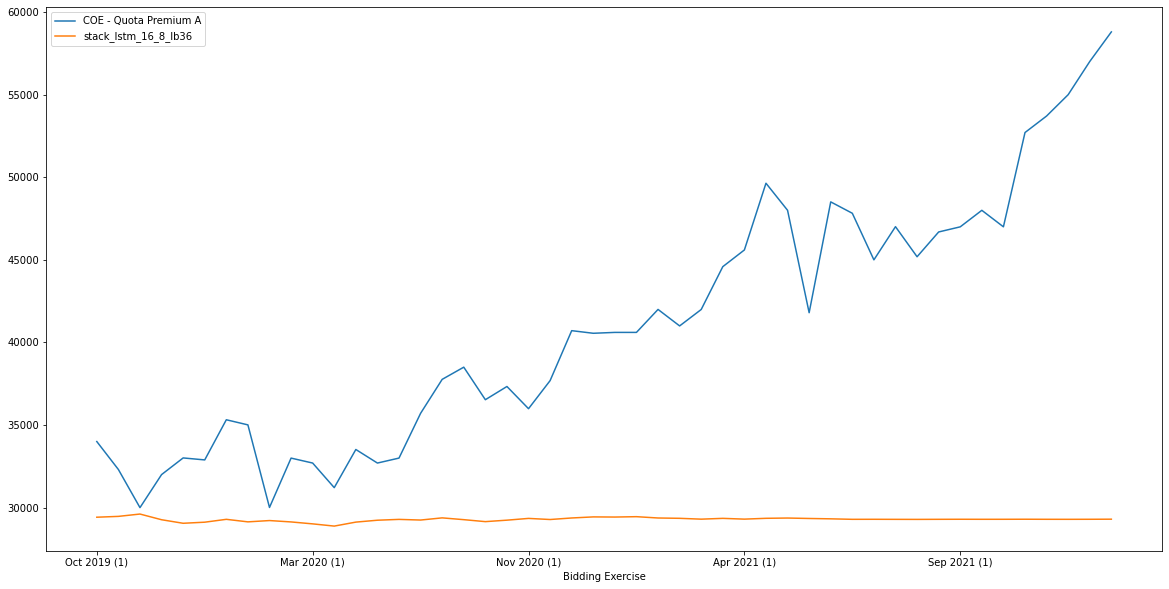

In [102]:
# load model and scaler
lstm_model = load_model(model_path)
lstm_scaler = joblib.load(scaler_path) 

# load and transform data
testX = val_nn_dataset[-look_back:].reshape(1,-1)
testPredict = make_forecasts(lstm_model, testX, 48)
testPredict = lstm_scaler.inverse_transform(testPredict)
testY = test_nn_dataset
testY = lstm_scaler.inverse_transform(testY)

# make forecasts
lstm_forecast_df = test_dataset.copy()
lstm_forecast_df['stack_lstm_16_8_lb36'] = testPredict[:,0]
actual_lstm_forecast_df = pd.concat([train_dataset, lstm_forecast_df], axis=0)
actual_lstm_forecast_df.iloc[-num_weeks_forecast-1,1] = actual_lstm_forecast_df.iloc[-num_weeks_forecast-1,0] 
actual_lstm_forecast_df[cutoff:].plot(figsize=(20,10))

# print errors
print_errors(testY[:,0], testPredict[:,0])


In [97]:
actual_lstm_forecast_df[cutoff:].to_csv('stack_lstm_16_8_lb36.csv')

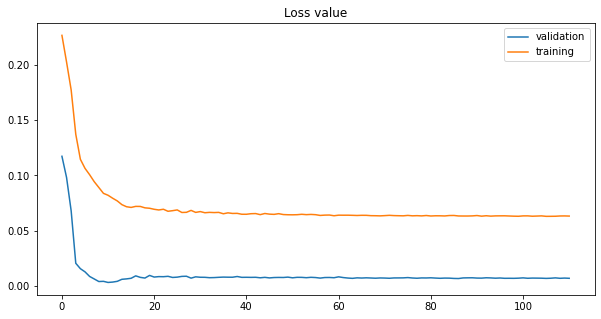

In [69]:
records = pd.read_csv(folderpath+model2name +'.csv')
plt.figure(figsize=(10,5))
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.title('Loss value',fontsize=12)
plt.legend()

### Best Stacked LSTM models
- lstm1(16), dropout(0.2), lstm2(16), dropout(0.2), dense(1), epochs=200, batch_size=4, look_back=36 -> MAPE=27.82%
- lstm1(16), dropout(0.2), lstm2(8), dropout(0.2), dense(1), epochs=200, batch_size=4, look_back=36 -> MAPE=23.74%
- lstm1(16), dropout(0.5), lstm2(16), dropout(0.5), dense(1), epochs=200, batch_size=4, look_back=36 -> MAPE=30.12%
- lstm1(16), dropout(0.2), lstm2(16), dropout(0.2), dense(1), epochs=200, batch_size=4, look_back=48 -> MAPE=29.53%
- lstm1(8), dropout(0), lstm2(8), dropout(0), dense(1), epochs=200, batch_size=4, look_back=48 -> MAPE=34.78%
- lstm1(8), dropout(0.1), lstm2(8), dropout(0), dense(1), epochs=200, batch_size=4, look_back=48 -> MAPE=29.72%
- lstm1(8), dropout(0.1), lstm2(8), dropout(0.1), dense(1), epochs=200, batch_size=4, look_back=48 -> MAPE=29.19%
- lstm1(16), dropout(0.25), lstm2(16), dropout(0.25), dense(1), epochs=200, batch_size=4, look_back=48 -> MAPE=27.4%
- lstm1(16), dropout(0.25), lstm2(16), dropout(0.25), dense(1), epochs=200, batch_size=4, look_back=36 -> MAPE=31.17%
- lstm1(16), dropout(0.2), lstm2(8), dropout(0.2), dense(1), epochs=200, batch_size=8, look_back=24 -> MAPE=27.79%
- lstm1(16), dropout(0.2), lstm2(8), dropout(0.2), dense(1), epochs=200, batch_size=16, look_back=36 -> MAPE=27.25%
Stacked LSTM model doesn't seem to perform as well as the single LSTM model, might be due ot the fact that we don't have enough data samples or features for a deeper neural network to work

In [111]:
forecasts_df = pd.read_csv(r'C:\Users\jengw\OneDrive\Desktop\NUS Masters\2. Pattern Recognition Systems\4. Practice Module\Code\combined_forecasts.csv', index_col=['bidding exercise'])
forecasts_df

,Quota Premium A,univariate_arima prediction,univariate_sarima prediction,univariate_holt-winters_single_HWES prediction,univariate_holt-winters_double_HWES1 prediction,univariate_holt-winters_double_HWES2 prediction,univariate_holt-winters_triple_HWES prediction,univariate_single_lstm prediction,univariate_stacked_lstm prediction,multivariate_varma prediction,multivariate_single_lstm prediction,multivariate_stacked_lstm prediction,multivariate_bidirectional_lstm prediction
bidding exercise,,,,,,,,,,,,,
Apr 2002 (1),37201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Apr 2002 (2),36000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
May 2002 (1),35000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
May 2002 (2),33401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Jun 2002 (1),33009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Oct 2021 (2),52709,25184.83866,68963.98306,39503.26321,24623.60944,34572.50007,28775.98323,46007.184,29298.055,41943.11183,43560.465,35331.277,36664.703
Nov 2021 (1),53709,25111.63983,72306.17872,39503.26321,24461.76549,34638.65136,28209.28850,46367.080,29293.980,42012.97648,41885.630,30098.676,43688.227
Nov 2021 (2),55001,25038.86189,73213.39221,39503.26321,24299.92155,34704.92923,26978.08070,46685.830,29292.455,42078.35629,44293.492,34131.050,38630.280


<AxesSubplot:xlabel='bidding exercise'>

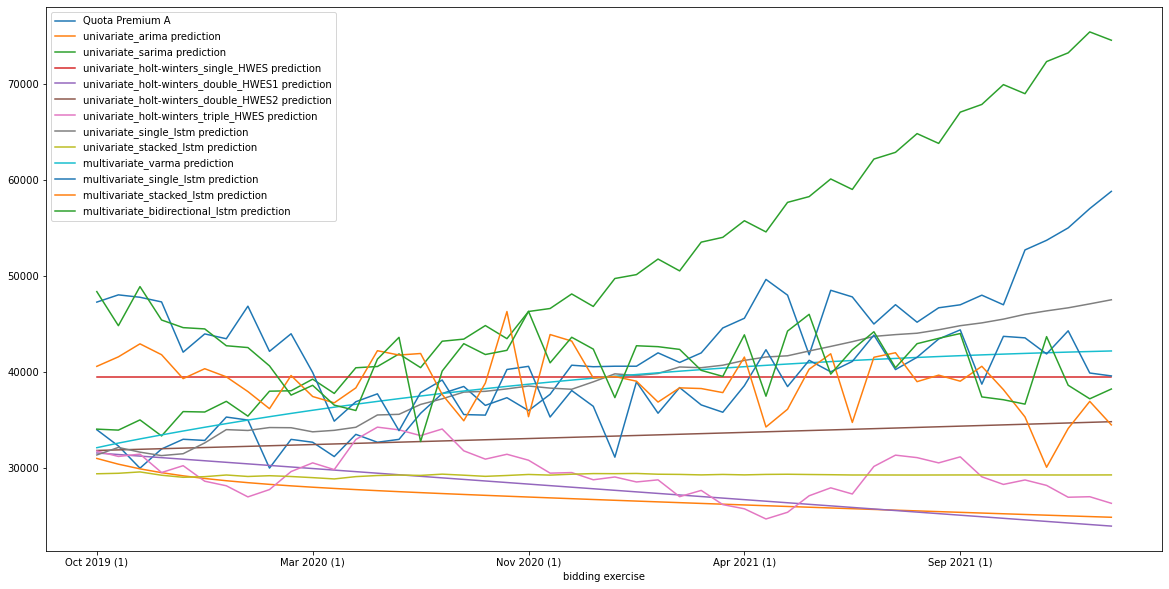

In [113]:
forecasts_df[cutoff:].plot(figsize=(20,10))

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
 

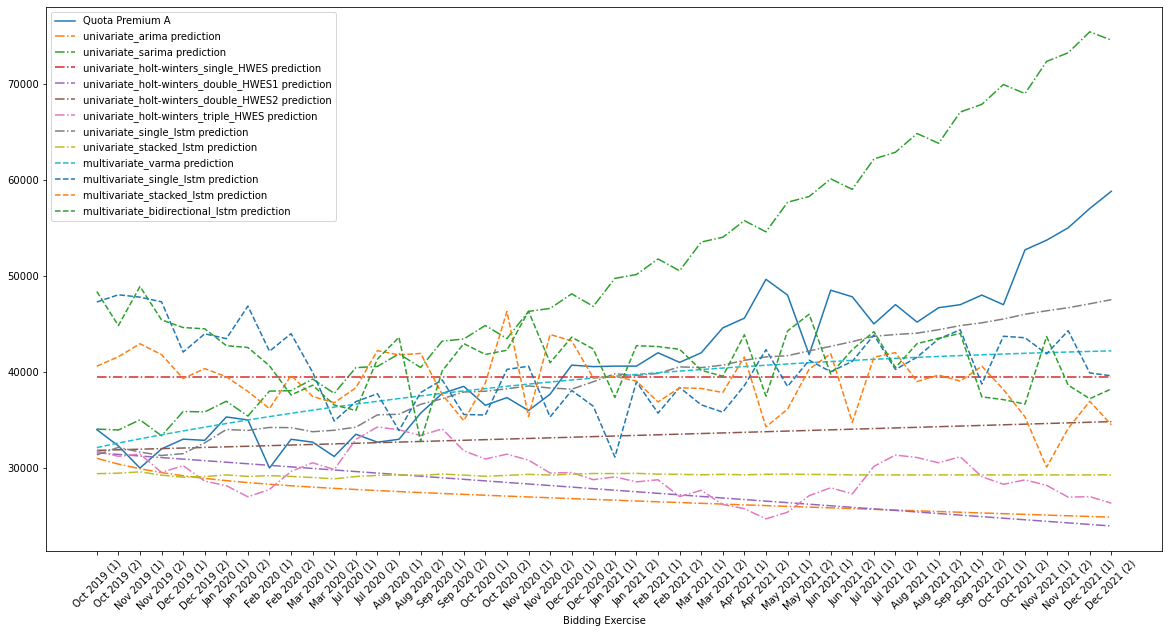

In [119]:
plt.figure(figsize=(20,10))
for col in forecasts_df.columns:
    temp_df = forecasts_df[[col]][cutoff:]
    if col[:3] == 'uni':
        plt.plot(temp_df, label=col, linestyle='-.')
    elif col[:5] == 'multi':
        plt.plot(temp_df, label=col, linestyle='--')
    else:
        plt.plot(temp_df, label=col)
        
plt.legend()
plt.xlabel('Bidding Exercise')
plt.xticks(rotation=45)
    